# Modeling

## Catboost

In [79]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline


    
# Diviser en train/test/validation avec stratification (important pour les données déséquilibrées)
X_train, X_temp, y_train, y_temp = train_test_split(
X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Diviser la partie temporaire en validation et test
X_val, X_test, y_val, y_test = train_test_split(
X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
    
print(f"Train: {X_train.shape}, positifs: {sum(y_train)}, ({sum(y_train)/len(y_train)*100:.3f}%)")
print(f"Validation: {X_val.shape}, positifs: {sum(y_val)}, ({sum(y_val)/len(y_val)*100:.3f}%)")
print(f"Test: {X_test.shape}, positifs: {sum(y_test)}, ({sum(y_test)/len(y_test)*100:.3f}%)")
                
# Approche 1: CatBoost avec scale_pos_weight pour les classes déséquilibrées
# Calculer le poids pour la classe minoritaire
scale_pos_weight = len(y_train) / sum(y_train) - 1
print(f"scale_pos_weight calculé: {scale_pos_weight:.2f}")

# Construire le pipeline avec préprocesseur
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        verbose=200,  # Réduire la verbosité
        random_state=42,
        eval_metric='F1',
        # Choisir UNE SEULE méthode de gestion du déséquilibre
        scale_pos_weight=scale_pos_weight,  # On garde celle-ci
        # auto_class_weights='Balanced',  # On supprime celle-ci
        loss_function='Logloss'
    ))
])

# Définir la grille de recherche adaptée aux données fortement déséquilibrées
param_grid = {
    'classifier__iterations': [500, 1200],
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__depth': [ 6, 8],
    'classifier__l2_leaf_reg': [1,  5],
    'classifier__random_strength': [1],
    # Paramètres spécifiques aux données déséquilibrées
    'classifier__scale_pos_weight': [scale_pos_weight, scale_pos_weight*1.5, scale_pos_weight*2],
    # Alternative: utiliser auto_class_weights au lieu de scale_pos_weight
    # 'classifier__auto_class_weights': ['Balanced', None]
}

# Cross-validation stratifiée pour préserver la distribution des classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV avec scoring='f1' pour optimiser le F1-score
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)



Train: (66963, 12), positifs: 135, (0.202%)
Validation: (14349, 12), positifs: 29, (0.202%)
Test: (14350, 12), positifs: 29, (0.202%)
scale_pos_weight calculé: 495.02


In [83]:
print("\n=== Début de la recherche par grille ===")
grid_search.fit(X_train, y_train)

# Récupérer le meilleur modèle
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\nMeilleur score F1 (CV): {grid_search.best_score_:.4f}")
print(f"Meilleurs paramètres trouvés: {best_params}")




=== Début de la recherche par grille ===
Fitting 5 folds for each of 48 candidates, totalling 240 fits
0:	learn: 0.9849202	total: 182ms	remaining: 1m 30s
200:	learn: 0.9998728	total: 6.5s	remaining: 9.67s
400:	learn: 0.9998728	total: 12.2s	remaining: 3.02s
499:	learn: 0.9998728	total: 14.8s	remaining: 0us

Meilleur score F1 (CV): 0.8552
Meilleurs paramètres trouvés: {'classifier__depth': 8, 'classifier__iterations': 500, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.05, 'classifier__random_strength': 1, 'classifier__scale_pos_weight': 495.02222222222224}


###  Calcul des prédictions

In [85]:
# Prédictions sur l'ensemble de validation
y_val_pred = best_pipeline.predict(X_val)
y_val_proba = best_pipeline.predict_proba(X_val)[:, 1]

# Prédictions sur l'ensemble de test
y_test_pred = best_pipeline.predict(X_test)
y_test_proba = best_pipeline.predict_proba(X_test)[:, 1]

### Évaluation sur l'ensemble de validation

In [87]:
# Évaluation sur l'ensemble de validation
print("\n=== Performances sur l'ensemble de validation ===")
print("\nMatrice de confusion:")
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
print(conf_matrix_val)

print("\nRapport de classification:")
print(classification_report(y_val, y_val_pred))

# Calcul du score AUC-ROC
val_auc = roc_auc_score(y_val, y_val_proba)
print(f"AUC-ROC: {val_auc:.4f}")


=== Performances sur l'ensemble de validation ===

Matrice de confusion:
[[14309    11]
 [    3    26]]

Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14320
           1       0.70      0.90      0.79        29

    accuracy                           1.00     14349
   macro avg       0.85      0.95      0.89     14349
weighted avg       1.00      1.00      1.00     14349

AUC-ROC: 0.9997


###  Évaluation sur l'ensemble de test

In [92]:
# Évaluation sur l'ensemble de test
print("\n=== Performances sur l'ensemble de test ===")
print("\nMatrice de confusion:")
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print(conf_matrix_test)

print("\nRapport de classification:")
print(classification_report(y_test, y_test_pred))

# Calcul du score AUC-ROC
test_auc = roc_auc_score(y_test, y_test_proba)
print(f"AUC-ROC: {test_auc:.4f}")


=== Performances sur l'ensemble de test ===

Matrice de confusion:
[[14313     8]
 [    2    27]]

Rapport de classification:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.77      0.93      0.84        29

    accuracy                           1.00     14350
   macro avg       0.89      0.97      0.92     14350
weighted avg       1.00      1.00      1.00     14350

AUC-ROC: 0.9999


### Visualisation des matrices de confusion

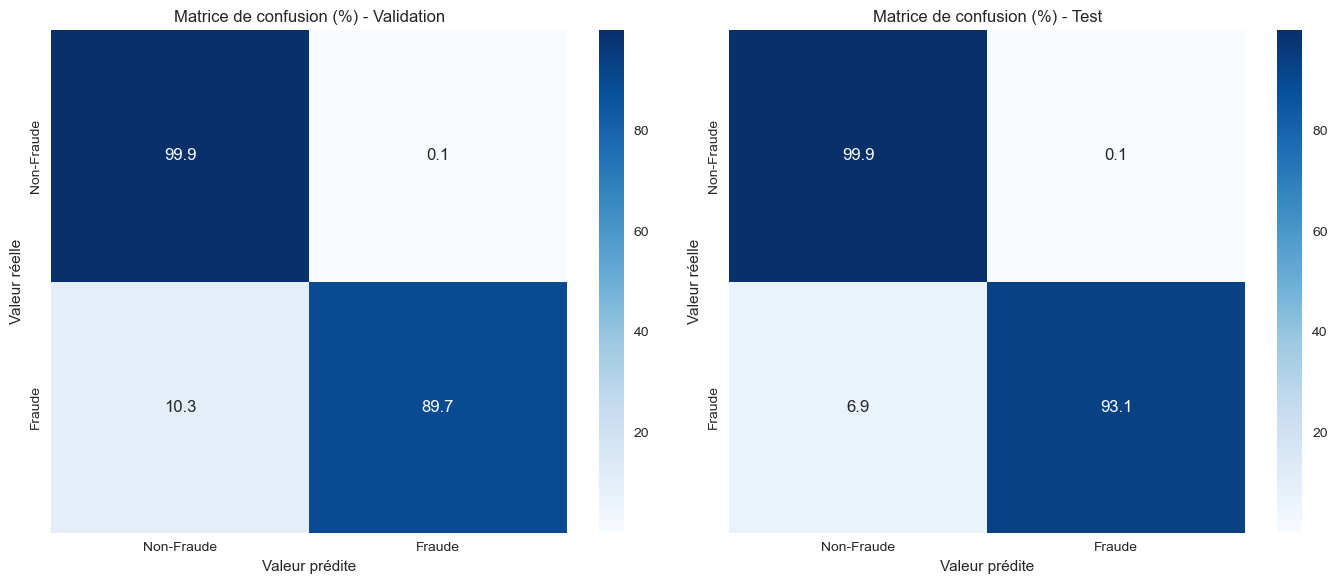


=== Matrice de confusion Validation (%) ===
                   Prédit Non-Fraude    Prédit Fraude
Réel Non-Fraude    99.9%              0.1%
Réel Fraude        10.3%              89.7%

=== Matrice de confusion Test (%) ===
                   Prédit Non-Fraude    Prédit Fraude
Réel Non-Fraude    99.9%              0.1%
Réel Fraude        6.9%              93.1%


In [111]:
# Visualisation de la matrice de confusion en pourcentage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convertir les matrices en pourcentage (normalisation par ligne)
conf_matrix_val_percent = np.zeros(conf_matrix_val.shape)
conf_matrix_test_percent = np.zeros(conf_matrix_test.shape)

# Normalisation par ligne pour la matrice de validation
for i in range(conf_matrix_val.shape[0]):
    row_sum = conf_matrix_val[i, :].sum()
    if row_sum > 0:
        conf_matrix_val_percent[i, :] = conf_matrix_val[i, :] / row_sum * 100

# Normalisation par ligne pour la matrice de test
for i in range(conf_matrix_test.shape[0]):
    row_sum = conf_matrix_test[i, :].sum()
    if row_sum > 0:
        conf_matrix_test_percent[i, :] = conf_matrix_test[i, :] / row_sum * 100

# Création des visualisations
plt.figure(figsize=(14, 6))

# Matrice de confusion de validation en pourcentage
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_val_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Non-Fraude', 'Fraude'], 
            yticklabels=['Non-Fraude', 'Fraude'])
plt.title('Matrice de confusion (%) - Validation')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')

# Matrice de confusion de test en pourcentage
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_test_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=['Non-Fraude', 'Fraude'], 
            yticklabels=['Non-Fraude', 'Fraude'])
plt.title('Matrice de confusion (%) - Test')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')

plt.tight_layout()
plt.show()

# Afficher aussi les valeurs numériques dans le terminal
print("\n=== Matrice de confusion Validation (%) ===")
print("                   Prédit Non-Fraude    Prédit Fraude")
print(f"Réel Non-Fraude    {conf_matrix_val_percent[0, 0]:.1f}%              {conf_matrix_val_percent[0, 1]:.1f}%")
print(f"Réel Fraude        {conf_matrix_val_percent[1, 0]:.1f}%              {conf_matrix_val_percent[1, 1]:.1f}%")

print("\n=== Matrice de confusion Test (%) ===")
print("                   Prédit Non-Fraude    Prédit Fraude")
print(f"Réel Non-Fraude    {conf_matrix_test_percent[0, 0]:.1f}%              {conf_matrix_test_percent[0, 1]:.1f}%")
print(f"Réel Fraude        {conf_matrix_test_percent[1, 0]:.1f}%              {conf_matrix_test_percent[1, 1]:.1f}%")

### Precision/Recall

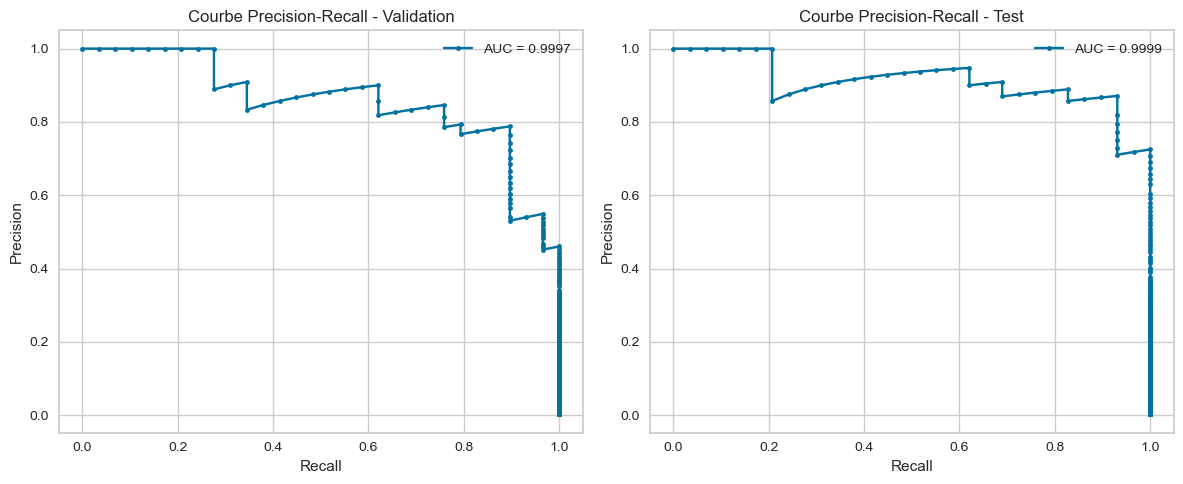

In [98]:
# Courbe Precision-Recall (particulièrement utile pour les données déséquilibrées)
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_proba)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(recall_val, precision_val, marker='.', label=f'AUC = {val_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Validation')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, marker='.', label=f'AUC = {test_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - Test')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
# Analyse des erreurs
# Identifier les cas mal classés
errors_idx = y_test != y_test_pred
X_errors = X_test[errors_idx]
y_true_errors = y_test[errors_idx]
y_pred_errors = y_test_pred[errors_idx]

print(f"\n=== Analyse des erreurs ===")
print(f"Nombre total d'erreurs: {sum(errors_idx)}")
print(f"Faux positifs: {sum((y_test == 0) & (y_test_pred == 1))}")
print(f"Faux négatifs: {sum((y_test == 1) & (y_test_pred == 0))}")


=== Analyse des erreurs ===
Nombre total d'erreurs: 10
Faux positifs: 8
Faux négatifs: 2


### Analyse des importances

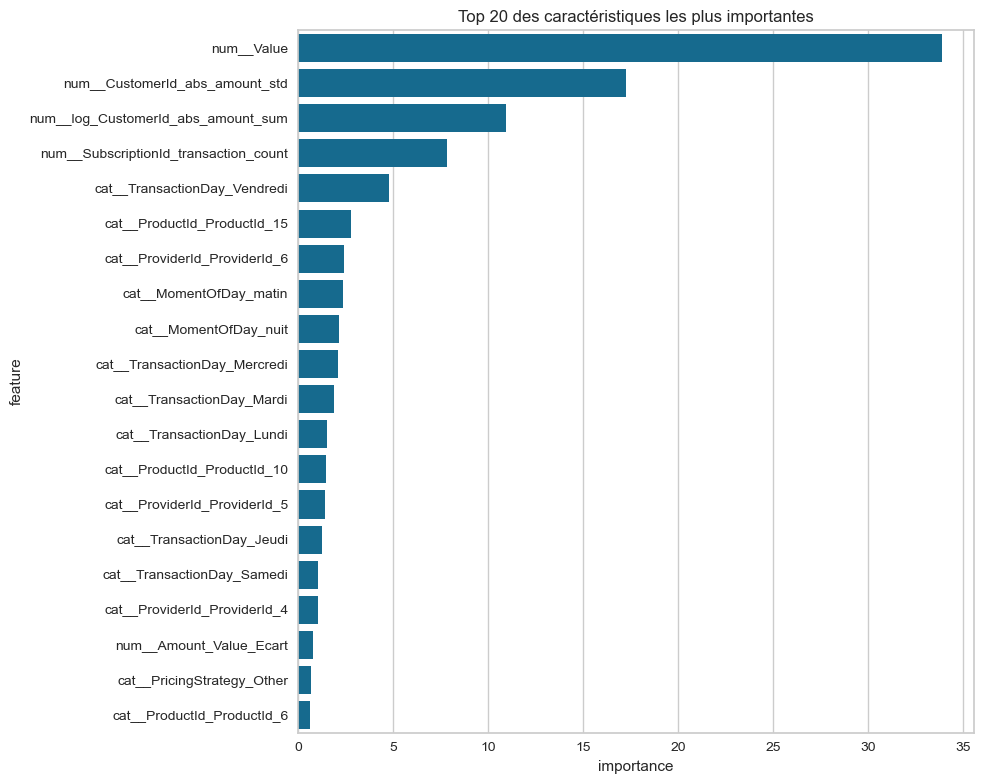

In [103]:
# Récupération des caractéristiques importantes
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
    
    # Si vous avez un préprocesseur qui modifie les noms de colonnes, 
    # vous devrez adapter cette partie pour obtenir les bons noms de caractéristiques
    try:
        # Essayer de récupérer les noms de caractéristiques transformées
        feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
    except:
        # Sinon, utiliser des noms génériques
        feature_names = [f"feature_{i}" for i in range(len(feature_importances))]
    
    # Afficher les 20 caractéristiques les plus importantes
    importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    importances = importances.sort_values('importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importances)
    plt.title('Top 20 des caractéristiques les plus importantes')
    plt.tight_layout()
    plt.show()

In [105]:
# Trouver le seuil optimal pour maximiser le F1-score
# Utile pour les données déséquilibrées
from sklearn.metrics import f1_score

# Calculer le F1-score pour différents seuils
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_val_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

# Trouver le seuil optimal
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"\n=== Seuil optimal ===")
print(f"Meilleur seuil: {best_threshold:.2f}, F1-score: {best_f1:.4f}")

# Appliquer le seuil optimal aux prédictions de test
y_test_pred_optimal = (y_test_proba >= best_threshold).astype(int)
test_f1_optimal = f1_score(y_test, y_test_pred_optimal)

print("\nMatrice de confusion avec seuil optimal:")
conf_matrix_optimal = confusion_matrix(y_test, y_test_pred_optimal)
print(conf_matrix_optimal)

print("\nRapport de classification avec seuil optimal:")
print(classification_report(y_test, y_test_pred_optimal))


=== Seuil optimal ===
Meilleur seuil: 0.70, F1-score: 0.8125

Matrice de confusion avec seuil optimal:
[[14315     6]
 [    2    27]]

Rapport de classification avec seuil optimal:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.82      0.93      0.87        29

    accuracy                           1.00     14350
   macro avg       0.91      0.97      0.94     14350
weighted avg       1.00      1.00      1.00     14350




=== Matrice de confusion après optimisation (pourcentages) ===
Seuil optimal utilisé: 0.7000000000000002
[[9.99581035e+01 4.18965156e-02]
 [6.89655172e+00 9.31034483e+01]]


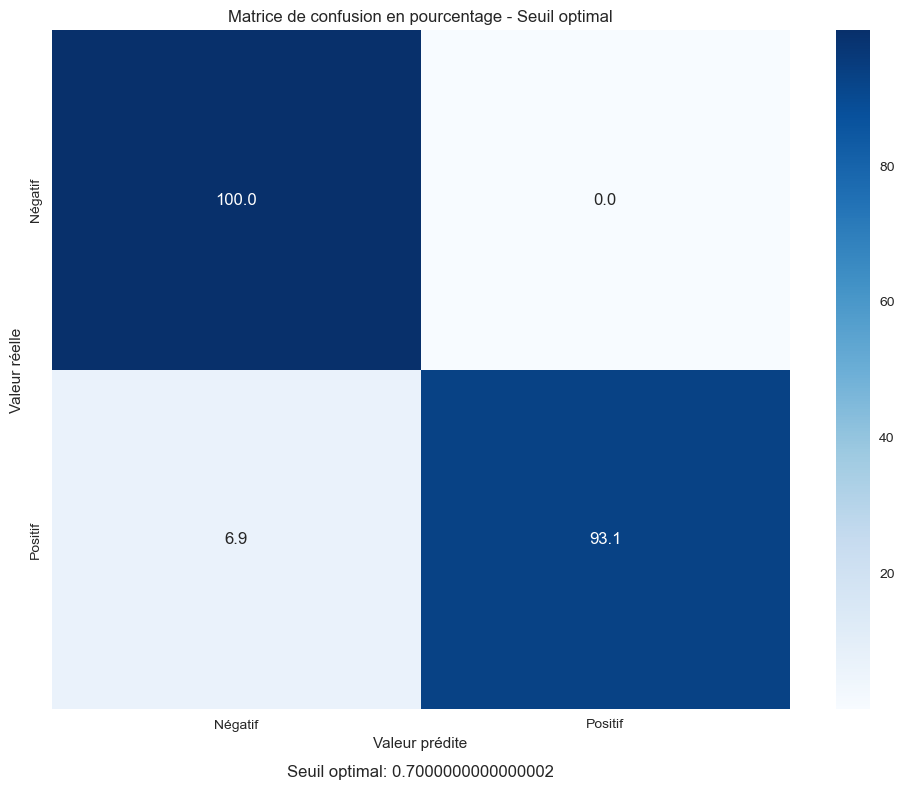


=== Rapport de classification avec seuil optimal ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14321
           1       0.82      0.93      0.87        29

    accuracy                           1.00     14350
   macro avg       0.91      0.97      0.94     14350
weighted avg       1.00      1.00      1.00     14350



In [107]:
# Calculer la matrice de confusion 
conf_matrix = confusion_matrix(y_test, y_test_pred_optimal)

# Convertir en pourcentages
conf_matrix_percent = np.zeros(conf_matrix.shape)

# Normalisation par ligne (chaque ligne représente la classe réelle et somme à 100%)
for i in range(conf_matrix.shape[0]):
    row_sum = conf_matrix[i, :].sum()
    if row_sum > 0:  # Éviter la division par zéro
        conf_matrix_percent[i, :] = conf_matrix[i, :] / row_sum * 100

print("\n=== Matrice de confusion après optimisation (pourcentages) ===")
print(f"Seuil optimal utilisé: {best_threshold}")
print(conf_matrix_percent)

# Visualisation de la matrice en pourcentage
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['Négatif', 'Positif'], yticklabels=['Négatif', 'Positif'])
plt.title('Matrice de confusion en pourcentage - Seuil optimal')
plt.ylabel('Valeur réelle')
plt.xlabel('Valeur prédite')
plt.text(0.5, -0.1, f"Seuil optimal: {best_threshold}", ha='center', 
         transform=plt.gca().transAxes, fontsize=12)
plt.tight_layout()
plt.show()

# Afficher le rapport de classification avec le seuil optimal
print("\n=== Rapport de classification avec seuil optimal ===")
print(classification_report(y_test, y_test_pred_optimal))

In [119]:
# Créer une version optimisée du pipeline qui utilise le seuil optimal
class OptimizedCatBoostPipeline:
    def __init__(self, pipeline, threshold):
        self.pipeline = pipeline
        self.threshold = threshold
    
    def predict(self, X):
        proba = self.pipeline.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        return self.pipeline.predict_proba(X)
    
    # Conserver les autres méthodes importantes du pipeline
    def __getattr__(self, name):
        return getattr(self.pipeline, name)

# Créer le modèle optimisé
optimized_model = OptimizedCatBoostPipeline(best_pipeline, best_threshold)
# Enregistrer le modèle avec dill
try:
    with open('optimized_catboost_model.dill', 'wb') as f:
        dill.dump(optimized_model, f)
    print("\nModèle optimisé enregistré avec succès dans 'optimized_catboost_model.dill'")
    
    # Vérifier que le modèle peut être rechargé
    with open('optimized_catboost_model.dill', 'rb') as f:
        loaded_model = dill.load(f)
    
    # Vérifier que le modèle rechargé fonctionne correctement
    loaded_preds = loaded_model.predict(X_test[:5])
    print(f"Vérification du chargement - Prédictions sur 5 exemples: {loaded_preds}")
    
except Exception as e:
    print(f"Erreur lors de l'enregistrement du modèle: {e}")
    
    # Alternative: enregistrer juste le pipeline et le seuil séparément
    print("Tentative d'enregistrement du pipeline de base...")
    with open('best_pipeline.dill', 'wb') as f:
        dill.dump(best_pipeline, f)
    
    # Enregistrer le seuil dans un fichier texte
    with open('optimal_threshold.txt', 'w') as f:
        f.write(str(best_threshold))
    
    print("Pipeline et seuil optimal enregistrés séparément")


Modèle optimisé enregistré avec succès dans 'optimized_catboost_model.dill'
Erreur lors de l'enregistrement du modèle: maximum recursion depth exceeded
Tentative d'enregistrement du pipeline de base...
Pipeline et seuil optimal enregistrés séparément


# FIN